In [6]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
# from tqdm import tqdm_notebook
%matplotlib inline 
# from google.colab.patches import cv2_imshow
from IPython.display import HTML #imports to play videos
from base64 import b64encode 
from skimage.metrics import structural_similarity
import glob
import time
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from tqdm import tqdm

import math
import pickle
from functools import partial
from collections import defaultdict


import cv2
import skimage.measure
import albumentations as A
from tqdm.notebook import tqdm 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.video import mc3_18, r2plus1d_18

from facenet_pytorch import MTCNN

import sys
import sklearn
import tensorflow as tf


import plotly.graph_objs as go
from plotly.offline import iplot

In [3]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def detect_face_cv2(img):
    # Move to grayscale
    gray_img = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2GRAY)
    face_locations = []
    face_rects = face_cascade.detectMultiScale(gray_img, scaleFactor=1.3, minNeighbors=5)     
    for (x,y,w,h) in face_rects: 
        face_location = (x,y,w,h)
        face_locations.append((face_location, 1.0))
    return face_locations

In [4]:
from mtcnn import MTCNN
detector = MTCNN()

def detect_face_mtcnn(img):
    face_locations = []
    items = detector.detect_faces(img)
    for face in items:
        face_location = tuple(face.get('box'))
        face_confidence = float(face.get('confidence'))
        face_locations.append((face_location, face_confidence))
    return face_locations

In [5]:
def extract_faces(files, source, detector=detect_face_cv2):
    results = []
    # for idx, file in tqdm(enumerate(files), total=len(files)):
    for idx, file in enumerate(files):
        try:
            img = cv2.cvtColor(cv2.imread(file, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
            face_locations = detector(img)
            results.append((source, file[file.find("output_"):], face_locations, len(face_locations)))
        except:
            print("Cannot extract faces for image: %s" % file)
    return results

In [10]:
tf.test.is_gpu_available()

False

In [12]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [15]:
meta = pd.read_csv('full_dataset.csv')

In [16]:
meta.head()

,path,label,resolution,frame_count,fps,set
0,Celeb-synthesis\id6_id2_0003.mp4,0,944x500,372.0,30.0,train
1,Celeb-synthesis\id49_id53_0006.mp4,0,856x478,330.0,30.0,train
2,YouTube-real\00105.mp4,1,892x500,504.0,30.0,train
3,Celeb-synthesis\id16_id30_0002.mp4,0,950x500,363.0,30.0,train
4,Celeb-synthesis\id6_id16_0003.mp4,0,944x500,372.0,30.0,train


In [17]:
meta.shape

(7047, 6)

In [19]:
len(meta[meta.label==0]),len(meta[meta.label==1])

(5979, 1068)

In [32]:
real_df = meta[meta["label"] == 1]
fake_df = meta[meta["label"] == 0]
sample_size = 1068

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [39]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.1,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.2,random_state=42,stratify=Train_set['label'])

In [40]:
Train_set.shape,Val_set.shape,Test_set.shape

((1537, 6), (385, 6), (214, 6))

In [41]:
import matplotlib.pyplot as plt

def plot_count(feature,  df, size=2, categories = 10):
    '''
    Plot count of classes / feature using only matplotlib
    param feature: the feature to analyze
    param title: title to add to the graph
    param df: dataframe from which we plot feature's classes distribution 
    param size: default 1.
    '''
    if df.empty or feature not in df.columns or df[feature].dropna().empty:
        print("DataFrame is empty or feature does not exist.")
        return

    total = float(len(df))
    if total == 0:
        print("DataFrame has no data.")
        return

    # Count occurrences of each category
    value_counts = df[feature].value_counts().nlargest(categories)  # Focus on the top 20 categories, similar to the Seaborn version

    f, ax = plt.subplots(1, 1, figsize=(4*size, 4*size))
    bars = ax.bar(value_counts.index, value_counts.values, color='salmon')  # Use bar plot from matplotlib

    ax.set_xlabel(feature)
    ax.set_ylabel('Counts')

    if len(value_counts) > 5:
        plt.xticks(rotation=45)

    # Annotate the bars with percentages
    for bar in bars:
        height = bar.get_height()
        percentage = 100 * height / total
        ax.text(bar.get_x() + bar.get_width() / 2, height + 3, f'{percentage:.2f}%', ha='center', va='bottom')

    plt.show()

# Example usage assuming df is your DataFrame and 'feature' is the column you want to analyze:
# plot_count('your_feature_column', 'Distribution of Feature', df)


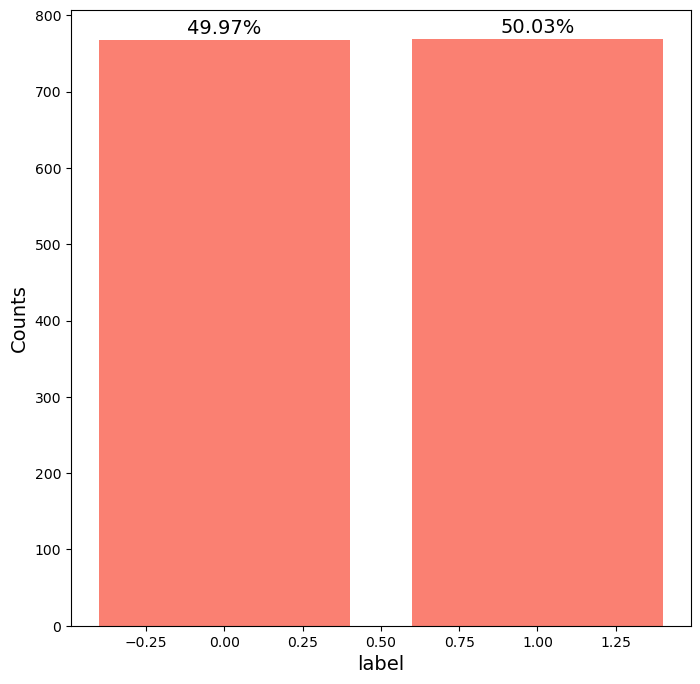

In [42]:
plot_count('label', Train_set)

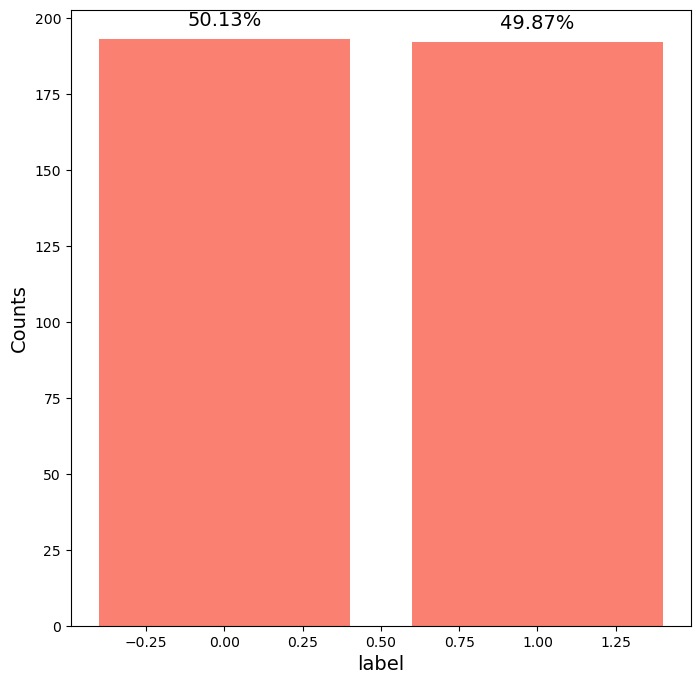

In [43]:
plot_count('label', Val_set)

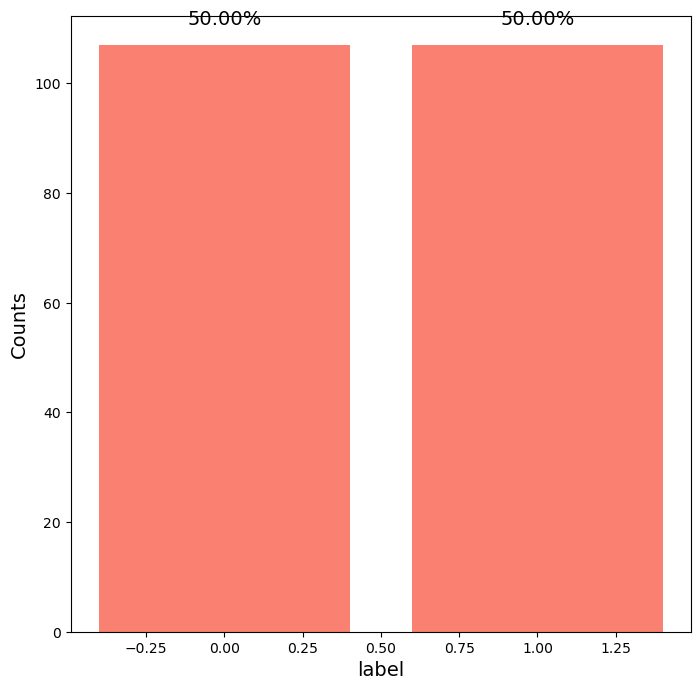

In [44]:
plot_count('label', Test_set)

In [ ]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread('../input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    
    if(Train_set.loc[i,'label']==0):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()